In [ ]:
# Update machine 
%pip install fastbook --upgrade

In [26]:
# Import moduals
from fastai.vision.all import *
#from google.colab import drive # uncomment if using google colab
import torch.nn as nn
import torch.nn.functional as F
from sklearn import metrics
from sklearn.metrics import *

SET UP DATASET

In [ ]:
# Access google drive (Change to location you put dataset in google drive and uncomment this section if using google colab)
'''drive.mount('content/', force_remount = True)
path = 'content/My Drive/University/spring 2024/CSC 451/Assignments/Assignment Two/CSC451_SP24_datasets/Cal256_26/'
!ls "{path}" '''

In [2]:
# Spliting image dataset into train-validation and test sets
# get list of all image files in 'path' (change to where you put the dataset folder)
path =  r'C:\Users\jmrxc\OneDrive\Documents\University\spring 2024\CSC 451\Term Project\dataset' # comment out if using google colab
image_files = get_image_files(path)
# dataset size
num_samples = len(image_files)
# the size of the test set
test_frac = 0.2
num_test = int(num_samples*test_frac)
# list indices of all images
idxs = np.arange(num_samples)
# randomly shuffle the indices
np.random.shuffle(idxs)
# split indices into those for train-validation set and test set
trainvalid_idxs, test_idxs = idxs[num_test:], idxs[:num_test]
# image files corresponding to the train-validation set and the test set
trainvalid_image_files, test_image_files = image_files[trainvalid_idxs], image_files[test_idxs]
# see the number of examples in the train-validation set and the test set
len(trainvalid_image_files), len(test_image_files)

(2728, 682)

LOAD DLS

In [3]:
# create PyTorch dataloaders (train and validation) from the image files
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       get_items = lambda x: trainvalid_image_files,
                       splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
                       get_y = lambda x: x.parent.name,
                       item_tfms = Resize(224),
                       batch_tfms = [Normalize.from_stats(*imagenet_stats)])

dls = dblock.dataloaders(path, device=torch.device('cuda'))
# see the labels present in the train set
dls.train.vocab

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'low_a', 'low_b', 'low_c', 'low_d', 'low_e', 'low_f', 'low_g', 'low_h', 'low_i', 'low_j', 'low_k', 'low_l', 'low_m', 'low_n', 'low_o', 'low_p', 'low_q', 'low_r', 'low_s', 'low_t', 'low_u', 'low_v', 'low_w', 'low_x', 'low_y', 'low_z', 'up_a', 'up_b', 'up_c', 'up_d', 'up_e', 'up_f', 'up_g', 'up_h', 'up_i', 'up_j', 'up_k', 'up_l', 'up_m', 'up_n', 'up_o', 'up_p', 'up_q', 'up_r', 'up_s', 'up_t', 'up_u', 'up_v', 'up_w', 'up_x', 'up_y', 'up_z']

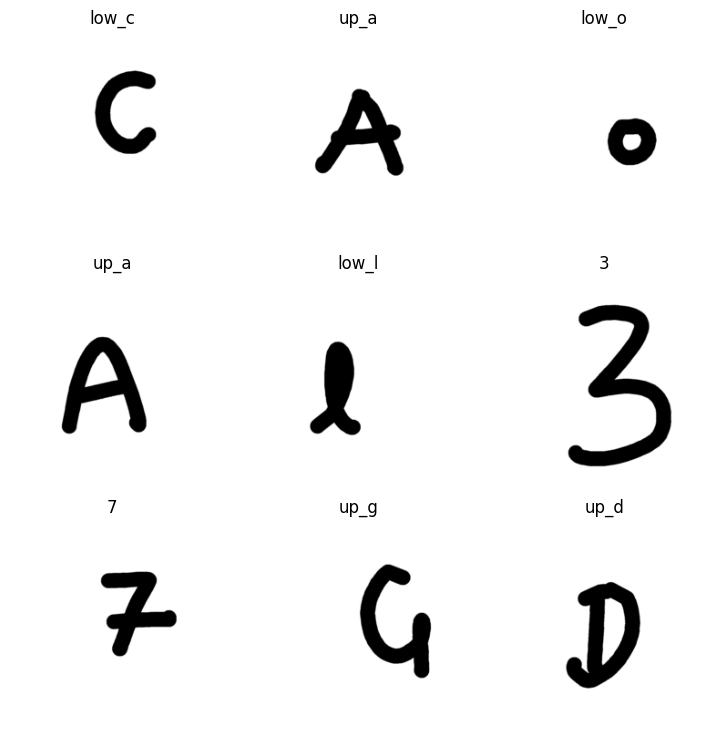

In [4]:
# show randomly sampled images and labels from the validation dataloader
dls.show_batch()

VGG EXPERIMENT

C:\Users\jmrxc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jmrxc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0012022644514217973)

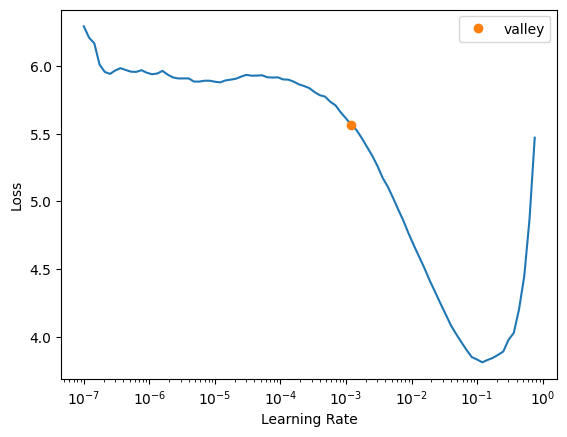

In [14]:
# VGG learner definition
learn_vgg = vision_learner(dls, vgg19, metrics = accuracy)
learn_vgg.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,4.393670,1.924067,0.482569,02:19


Better model found at epoch 0 with valid_loss value: 1.9240673780441284.


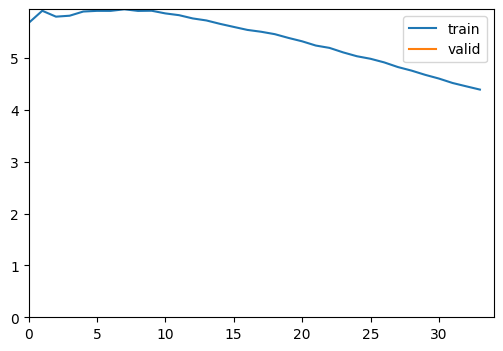

epoch,train_loss,valid_loss,accuracy,time
0,2.118878,1.449182,0.627523,05:41
1,1.823360,1.084556,0.715596,05:46
2,1.490429,0.842628,0.779817,05:43
3,1.202943,0.693983,0.829358,05:45
4,0.966228,0.612379,0.820184,05:43
5,0.774184,0.565712,0.849541,05:45
6,0.624224,0.533711,0.849541,05:43
7,0.502586,0.503284,0.849541,05:45
8,0.418445,0.496499,0.856881,05:41
9,0.358573,0.474341,0.860550,05:46


Better model found at epoch 0 with valid_loss value: 1.4491816759109497.


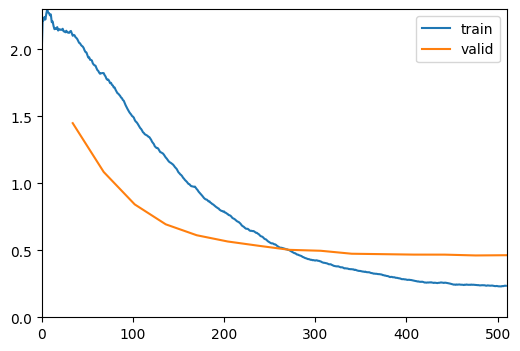

Better model found at epoch 1 with valid_loss value: 1.0845558643341064.
Better model found at epoch 2 with valid_loss value: 0.8426275253295898.
Better model found at epoch 3 with valid_loss value: 0.6939828991889954.
Better model found at epoch 4 with valid_loss value: 0.6123793721199036.
Better model found at epoch 5 with valid_loss value: 0.5657119154930115.
Better model found at epoch 6 with valid_loss value: 0.5337112545967102.
Better model found at epoch 7 with valid_loss value: 0.5032836198806763.
Better model found at epoch 8 with valid_loss value: 0.49649903178215027.
Better model found at epoch 9 with valid_loss value: 0.4743408262729645.
Better model found at epoch 10 with valid_loss value: 0.47116899490356445.
Better model found at epoch 11 with valid_loss value: 0.46783876419067383.
Better model found at epoch 12 with valid_loss value: 0.4676035940647125.
Better model found at epoch 13 with valid_loss value: 0.46156156063079834.


In [15]:
# VGG training
learn_vgg.fine_tune(15, 0.0012022644514217973, cbs = [ShowGraphCallback(), EarlyStoppingCallback(min_delta=0.0001, patience=5), SaveModelCallback()])

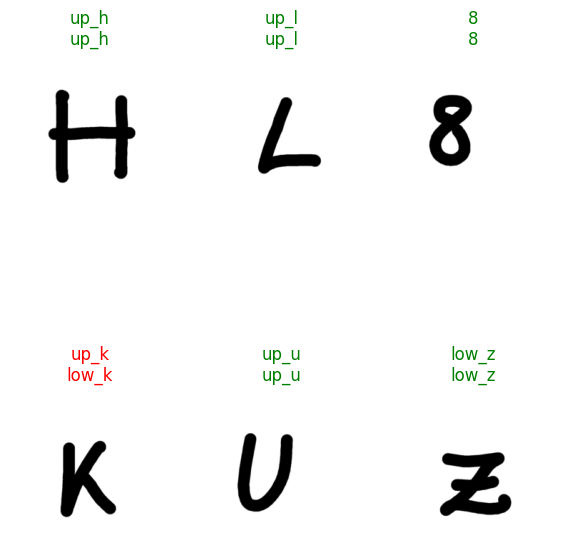

In [16]:
# visualize CNN results (top row: true labels, bottom row: predicted labels)
learn_vgg.show_results(max_n = 6, figsize=(7,8))

In [17]:
# Validation set accuracy and f1 score for VGG model
validationset_labels = [xy[-1] for xy in dls[1].dataset]
pred_probas, _, pred_classes = learn_vgg.get_preds(dl=dls[1], with_decoded=True)
print('Accuracy: %f' % accuracy_score(validationset_labels, pred_classes))
print('Precision: %f' % precision_score(validationset_labels, pred_classes, average = 'macro'))
print('Recall: %f' % recall_score(validationset_labels, pred_classes, average = 'macro'))
print('F1 Score: %f' % f1_score(validationset_labels, pred_classes, average='macro'))

Accuracy: 0.856881
Precision: 0.851062
Recall: 0.857707
F1 Score: 0.847365


In [18]:
# create a dataloader from the test set images using the same data preprocessing pipeline
# used in creating the train and validation dataloaders
test_dl = learn_vgg.dls.test_dl(test_image_files, with_labels=True)

# obtain the predictions on the test set
pred_probas, _, pred_classes = learn_vgg.get_preds(dl=test_dl, with_decoded=True)

# obtain the true labels (ground truth) for the test set images
test_labels = [xy[-1] for xy in test_dl.dataset]

# compute the test set accuracy, f1 score
print('Accuracy: %f' % accuracy_score(test_labels, pred_classes))
print('Precision: %f' % precision_score(test_labels, pred_classes, average = 'macro'))
print('Recall: %f' % recall_score(test_labels, pred_classes, average = 'macro'))
print('F1 Score: %f' % f1_score(test_labels, pred_classes, average='macro'))

Accuracy: 0.885630
Precision: 0.885351
Recall: 0.884917
F1 Score: 0.880034


RESNET EXPERIMENT

SuggestedLRs(valley=0.0014454397605732083)

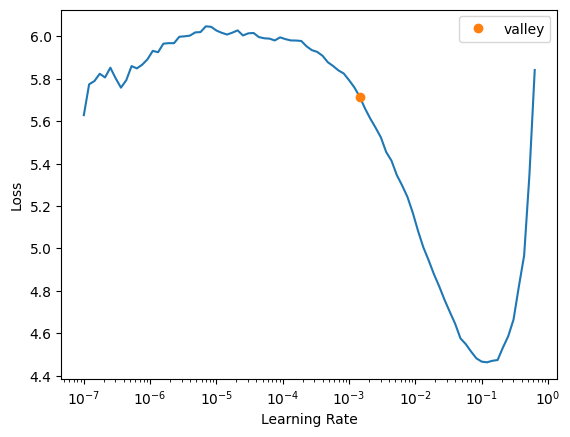

In [9]:
# ResNet learner definition and learning rate finder
learn_resnet = vision_learner(dls, resnet152, metrics = accuracy)
learn_resnet.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,4.781449,5.651402,0.067890,02:21


Better model found at epoch 0 with valid_loss value: 5.651402473449707.


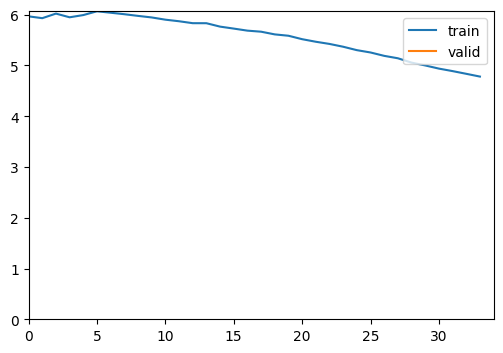

epoch,train_loss,valid_loss,accuracy,time
0,2.781396,2.929573,0.299083,02:57
1,2.308812,1.415639,0.594495,02:55
2,1.813616,0.995789,0.704587,02:59
3,1.361873,0.727259,0.788991,02:59
4,1.013632,0.581074,0.814679,02:56
5,0.760087,0.538697,0.825688,02:55
6,0.592666,0.488293,0.853211,03:00
7,0.453996,0.405343,0.866055,02:59
8,0.358188,0.408984,0.860550,02:57
9,0.278412,0.398093,0.869725,02:52


Better model found at epoch 0 with valid_loss value: 2.9295730590820312.


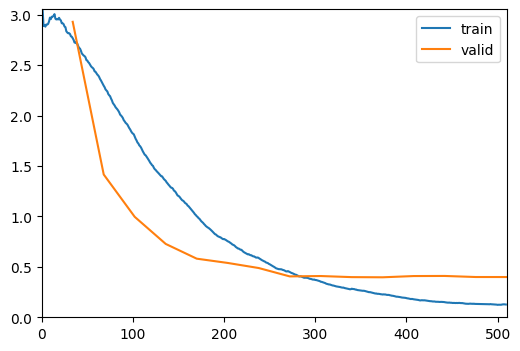

Better model found at epoch 1 with valid_loss value: 1.4156392812728882.
Better model found at epoch 2 with valid_loss value: 0.9957886934280396.
Better model found at epoch 3 with valid_loss value: 0.7272588610649109.
Better model found at epoch 4 with valid_loss value: 0.5810739994049072.
Better model found at epoch 5 with valid_loss value: 0.5386971831321716.
Better model found at epoch 6 with valid_loss value: 0.48829302191734314.
Better model found at epoch 7 with valid_loss value: 0.40534287691116333.
Better model found at epoch 9 with valid_loss value: 0.39809268712997437.
Better model found at epoch 10 with valid_loss value: 0.3964274227619171.


In [10]:
# ResNet training
learn_resnet.fine_tune(15, 0.0014454397605732083, cbs = [ShowGraphCallback(), EarlyStoppingCallback(min_delta=0.0001, patience=5), SaveModelCallback()])

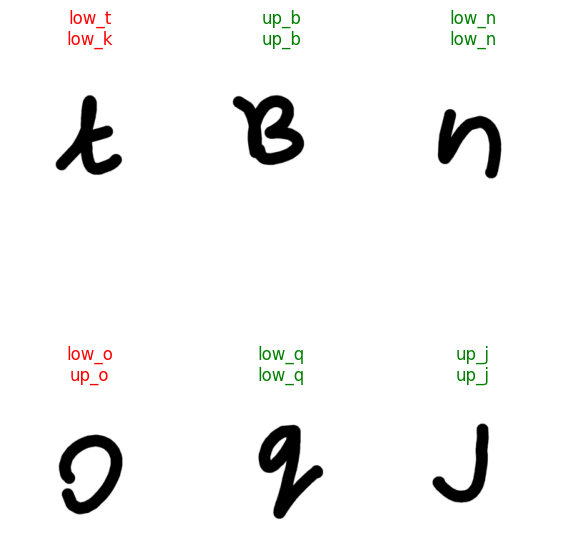

In [11]:
# visualize CNN results (top row: true labels, bottom row: predicted labels)
learn_resnet.show_results(max_n = 6, figsize=(7,8))

In [12]:
# Validation set accuracy and f1 score for ResNet model
validationset_labels = [xy[-1] for xy in dls[1].dataset]
pred_probas, _, pred_classes = learn_resnet.get_preds(dl=dls[1], with_decoded=True)
print('Accuracy: %f' % accuracy_score(validationset_labels, pred_classes))
print('Precision: %f' % precision_score(validationset_labels, pred_classes, average = 'macro'))
print('Recall: %f' % recall_score(validationset_labels, pred_classes, average = 'macro'))
print('F1 Score: %f' % f1_score(validationset_labels, pred_classes, average='macro'))

Accuracy: 0.866055
Precision: 0.856599
Recall: 0.860478
F1 Score: 0.850707


In [13]:
# create a dataloader from the test set images using the same data preprocessing pipeline
# used in creating the train and validation dataloaders
test_dl = learn_resnet.dls.test_dl(test_image_files, with_labels=True)

# obtain the predictions on the test set
pred_probas, _, pred_classes = learn_resnet.get_preds(dl=test_dl, with_decoded=True)

# obtain the true labels (ground truth) for the test set images
test_labels = [xy[-1] for xy in test_dl.dataset]

# compute the test set accuracy, f1 score
print('Accuracy: %f' % accuracy_score(test_labels, pred_classes))
print('Precision: %f' % precision_score(test_labels, pred_classes, average = 'macro'))
print('Recall: %f' % recall_score(test_labels, pred_classes, average = 'macro'))
print('F1 Score: %f' % f1_score(test_labels, pred_classes, average='macro'))

Accuracy: 0.848974
Precision: 0.853380
Recall: 0.851173
F1 Score: 0.843673


DENSENET EXPERIMENT

SuggestedLRs(valley=0.0005754399462603033)

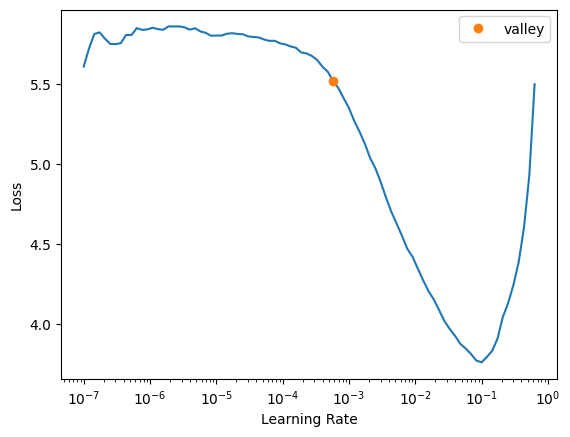

In [5]:
# DenseNet learner definition and learning rate finder
learn_dense = vision_learner(dls, densenet201, metrics = accuracy)
learn_dense.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,4.493238,3.244821,0.174312,01:54


Better model found at epoch 0 with valid_loss value: 3.2448205947875977.


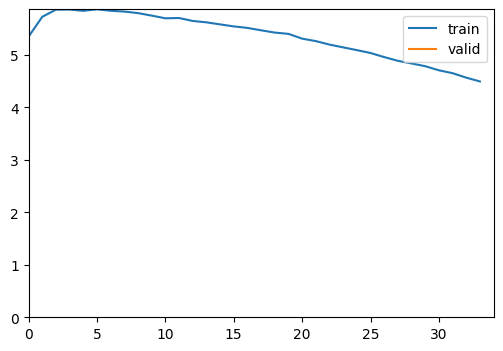

epoch,train_loss,valid_loss,accuracy,time
0,2.314496,1.862177,0.484404,02:30
1,1.956756,1.184712,0.658716,02:30
2,1.569026,0.838864,0.763303,02:28
3,1.215779,0.656814,0.809174,02:31
4,0.937636,0.565145,0.825688,02:29
5,0.728311,0.503555,0.849541,02:31
6,0.569099,0.484713,0.847706,02:30
7,0.456399,0.474274,0.838532,02:29
8,0.363724,0.418268,0.862385,02:30
9,0.314306,0.420307,0.869725,02:29


Better model found at epoch 0 with valid_loss value: 1.8621774911880493.


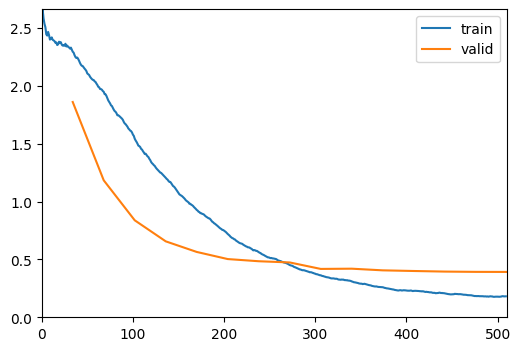

Better model found at epoch 1 with valid_loss value: 1.1847118139266968.
Better model found at epoch 2 with valid_loss value: 0.8388644456863403.
Better model found at epoch 3 with valid_loss value: 0.6568138003349304.
Better model found at epoch 4 with valid_loss value: 0.5651451349258423.
Better model found at epoch 5 with valid_loss value: 0.5035554766654968.
Better model found at epoch 6 with valid_loss value: 0.48471343517303467.
Better model found at epoch 7 with valid_loss value: 0.4742738604545593.
Better model found at epoch 8 with valid_loss value: 0.4182675778865814.
Better model found at epoch 10 with valid_loss value: 0.4059692621231079.
Better model found at epoch 11 with valid_loss value: 0.40033814311027527.
Better model found at epoch 12 with valid_loss value: 0.39525148272514343.
Better model found at epoch 13 with valid_loss value: 0.39280933141708374.
Better model found at epoch 14 with valid_loss value: 0.39219000935554504.


In [6]:
# DenseNet training
learn_dense.fine_tune(15, 0.0005754399462603033, cbs = [ShowGraphCallback(), EarlyStoppingCallback(min_delta=0.0001, patience=5), SaveModelCallback()])

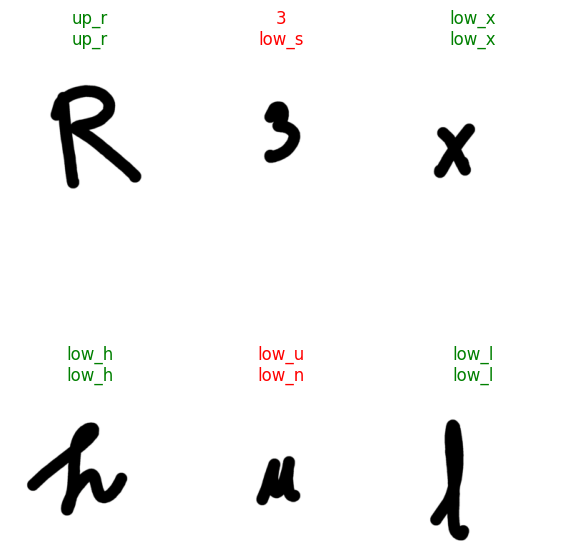

In [7]:
# visualize CNN results (top row: true labels, bottom row: predicted labels)
learn_dense.show_results(max_n = 6, figsize=(7,8))

In [8]:
# Validation set accuracy and f1 score for DenseNet model
validationset_labels = [xy[-1] for xy in dls[1].dataset]
pred_probas, _, pred_classes = learn_dense.get_preds(dl=dls[1], with_decoded=True)
print('Accuracy: %f' % accuracy_score(validationset_labels, pred_classes))
print('Precision: %f' % precision_score(validationset_labels, pred_classes, average = 'macro'))
print('Recall: %f' % recall_score(validationset_labels, pred_classes, average = 'macro'))
print('F1 Score: %f' % f1_score(validationset_labels, pred_classes, average='macro'))

Accuracy: 0.880734
Precision: 0.877265
Recall: 0.873793
F1 Score: 0.868230


In [19]:
# create a dataloader from the test set images using the same data preprocessing pipeline
# used in creating the train and validation dataloaders
test_dl = learn_dense.dls.test_dl(test_image_files, with_labels=True)

# obtain the predictions on the test set
pred_probas, _, pred_classes = learn_dense.get_preds(dl=test_dl, with_decoded=True)

# obtain the true labels (ground truth) for the test set images
test_labels = [xy[-1] for xy in test_dl.dataset]

# compute the test set accuracy, f1 score
print('Accuracy: %f' % accuracy_score(test_labels, pred_classes))
print('Precision: %f' % precision_score(test_labels, pred_classes, average = 'macro'))
print('Recall: %f' % recall_score(test_labels, pred_classes, average = 'macro'))
print('F1 Score: %f' % f1_score(test_labels, pred_classes, average='macro'))

Accuracy: 0.868035
Precision: 0.876785
Recall: 0.865739
F1 Score: 0.865309


TEST SET PERFORMANCE ON BEST NETWORK

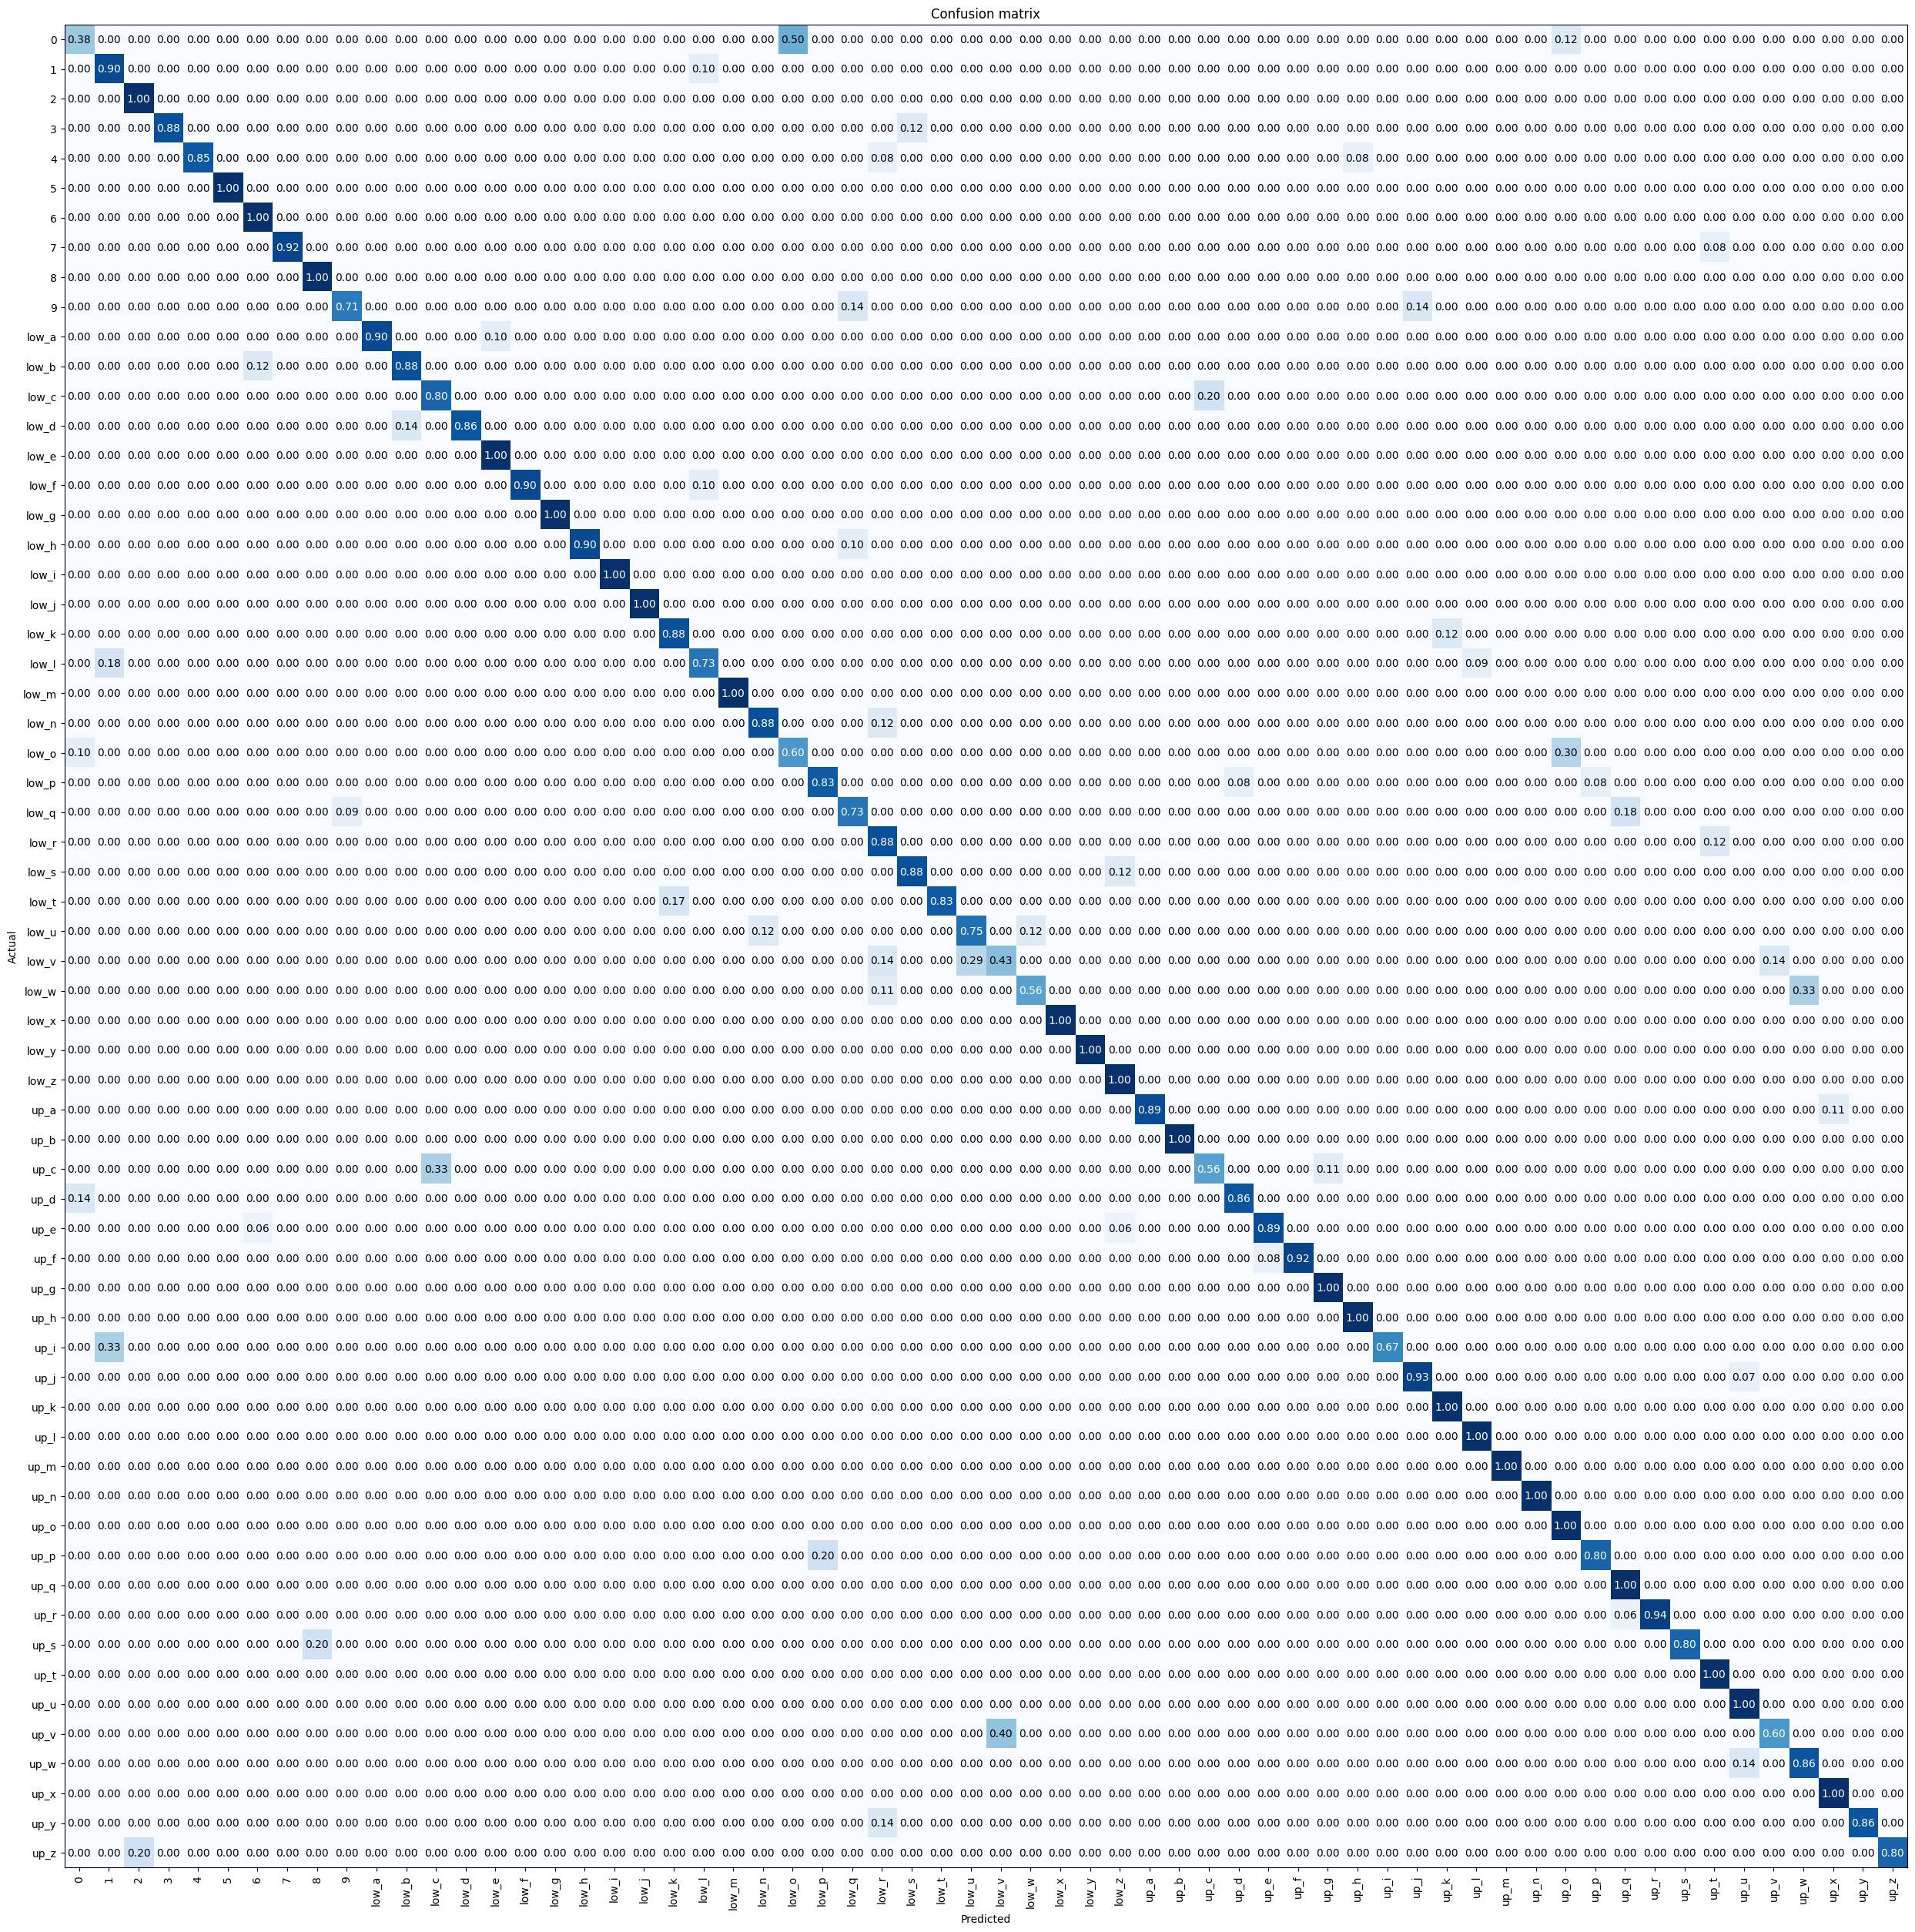

In [21]:
# generate confusion matrix (test set)
interp = ClassificationInterpretation.from_learner(learn_dense)
# show normalized confusion matrix
interp.plot_confusion_matrix(normalize=True, figsize=(25, 25))